# 🔰 In response to [this](https://stackoverflow.com/questions/72456522/lstm-multivariate-predicting-multiple-features/72458288#72458288) Stackoverflow question:

    I have 2 years of bitcoin historical dataset and bitcoin sentiment dataset which is of one hour interval.
    My goal is to predict next 60 hours future chart using LSTM.

    I have seen some of the articles regarding multivariate time series prediction. 
    But in all of them they are taking only one feature for prediction. They predict only the price of one upcoming day and . 
    So in order to predict next 2 months data, I have to predict all of the features. So that I can seed the predicted data as
    input for the next prediction and so on to predict for next 60 days. Can someone help me to figure out how can I do this 
    kind of prediction?

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# 🔰======= ✍**Create some data**

In [2]:
#============ Helper Function:
today = datetime.datetime.now()    # Get today's date as reference
delta = datetime.timedelta         # Used to generate random past dates

def _make_time_stamp(offset):
  return (today-delta(hours=offset)).strftime('%Y-%m-%d_%H')

def _make_price(max_p,samples):
  x = np.linspace(0,2*np.pi,samples)
  a0 = ((max_p-1)/(2*np.pi))*x + 1
  a1 = np.sin(x)/5 - np.sin(2*x)/4 + np.sin(3*x)/3 - np.sin(4*x)/4
  a2 = np.random.normal(0,0.025,samples)
  return a0+a1+a2

def _make_sent(price):
  d = 720
  s = price.copy()
  s[d:] = (price[d:]-price[:-d])*1.25
  s[:d] = np.random.normal(0.1,0.05,d)*1.25
  return s

def make_data(max_price,samples):
  time_stamps = [_make_time_stamp(offset) for offset in range(samples-1,-1,-1)]
  prices = _make_price(max_p=max_price,samples=samples)
  sentiment = _make_sent(prices)
  return time_stamps, prices, sentiment


In [3]:
#=========== Setup:
N_Years = 3                                                       # How far back should dates go
Days_Per_Year = 365
Samples_Per_Day = 24

N_Samples = N_Years*Days_Per_Year*Samples_Per_Day                 # Number of data points

#=========== Generate Data:
time_stamps,prices,sentiment = make_data(5,samples=N_Samples)


#=========== Make Dateframe:
df = pd.DataFrame.from_dict({'time_stamp':time_stamps,
                             'price':prices,
                             'sentiment':sentiment})

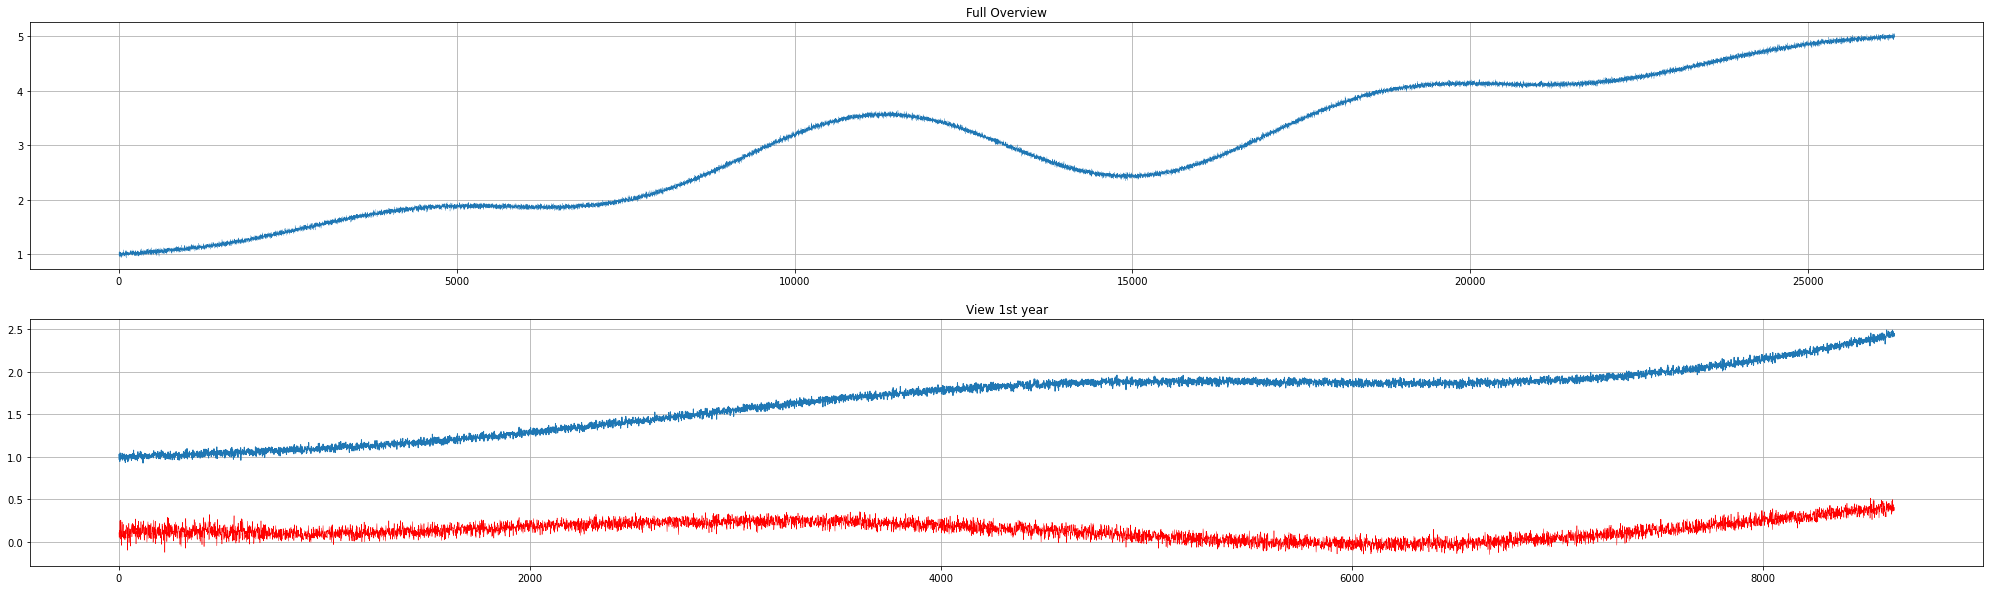

In [4]:
#======= View Price Data:
#== Setup:
fig,axs = plt.subplots(2,1,figsize=(35,10))

#== Plot:
d1,d2 = 0,720*12
ax = df['price'].plot(ax=axs[0],lw=0.25,title='Full Overview')
ax = df['price'].iloc[d1:d2].plot(ax=axs[1],lw=1,title='View 1st year')
ax = df['sentiment'].iloc[d1:d2].plot(ax=axs[1],lw=0.5,color='red')

#== Format:
_ = axs[0].grid(True), axs[1].grid(True)

# 🔰============= Make Time Series Data:
## [Tensorflow Source](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator)

In [10]:
def generator(data,xlen,ylen,xy_offset):
  #=== Setup
  last_idx = data.shape[0] - (ylen-1)
  start_idx = xlen+xy_offset+ylen
  Xp,Xs,Y = [],[],[]
  for fidy in range(start_idx,last_idx):
    #=== Split Y
    sidy = fidy-ylen
    y = data['price'].iloc[sidy:fidy]
    #=== Split X
    fidx = sidy-xy_offset
    sidx = fidx-xlen
    xp = data['price'].iloc[sidx:fidx]
    xs = data['sentiment'].iloc[sidx:fidx]
    
    Xp.append(xp)
    Xs.append(xs)
    Y.append(y)
  
  #=== Make tensors
  Xp = tf.constant(Xp)
  Xs = tf.constant(Xs)
  Y = tf.constant(Y)
  print(f'Xp shape: {Xp.shape}\nXs shape: {Xs.shape}\nY shape: {Y.shape}')
  return Xp,Xs,Y

In [16]:
X_price,X_sent,Y_price = generator(df,
                                   xlen=60,
                                   ylen=1,
                                   xy_offset=0)

Xp shape: (26219, 60)
Xs shape: (26219, 60)
Y shape: (26219, 1)


In [32]:
#==== Sanity Check: Review output
print(df['price'].iloc[0:61].to_numpy()[::10])
print(X_price[0][::10])
print(Y_price[0])

[0.97213234 0.9934735  1.00028762 0.97099355 0.99535632 0.99331132
 0.97190255]
tf.Tensor([0.97213234 0.9934735  1.00028762 0.97099355 0.99535632 0.99331132], shape=(6,), dtype=float64)
tf.Tensor([0.97190255], shape=(1,), dtype=float32)


# 🔰======= 🔧🧠🔨 **Build a model**

In [12]:
from tensorflow.keras.utils import plot_model

In [13]:
#================================= Design Model Architecture:
#==== Create Input Layers:
Price_Input = tf.keras.layers.Input(shape=(60,),name='Price_Input')                       #Price as Input
Sent_Input = tf.keras.layers.Input(shape=(60,),name='Sentiment_Input')                    #Sentiment as Input

#=== Handle Reshaping as part of the Model Architecture:
P_Input_rshp = tf.keras.layers.Reshape(target_shape=(60,1),
                                       input_shape=(60,),
                                       name='Price_Reshape')(Price_Input)                 #Pass price to reshape layer

S_Input_rshp = tf.keras.layers.Reshape(target_shape=(60,1),
                                       input_shape=(60,),
                                       name='Sentiment_Reshape')(Sent_Input)              #Pass sentiment to rehape layer

#=== Use LSTM layers for timeseries:
P_x = tf.keras.layers.LSTM(units=1,activation='tanh',name='Price_LSTM')(P_Input_rshp)     #Price Focused LSTM
S_x = tf.keras.layers.LSTM(units=1,activation='tanh',name='Sentiment_LSTM')(S_Input_rshp) #Sentiment Focused LSTM

C_x = tf.keras.layers.Concatenate(name='Concat')([P_x,S_x])                               #Concatinate(join) inputs from each branch

Output = tf.keras.layers.Dense(units=1,name='Dense')(C_x)                                 #Dense layer as model output to synthesize results


#================================= Greate Model Graph:
model = tf.keras.Model(inputs=[Price_Input,Sent_Input],
                       outputs=Output,
                       name='Double_LSTM_Model')                                          #Initilize Model


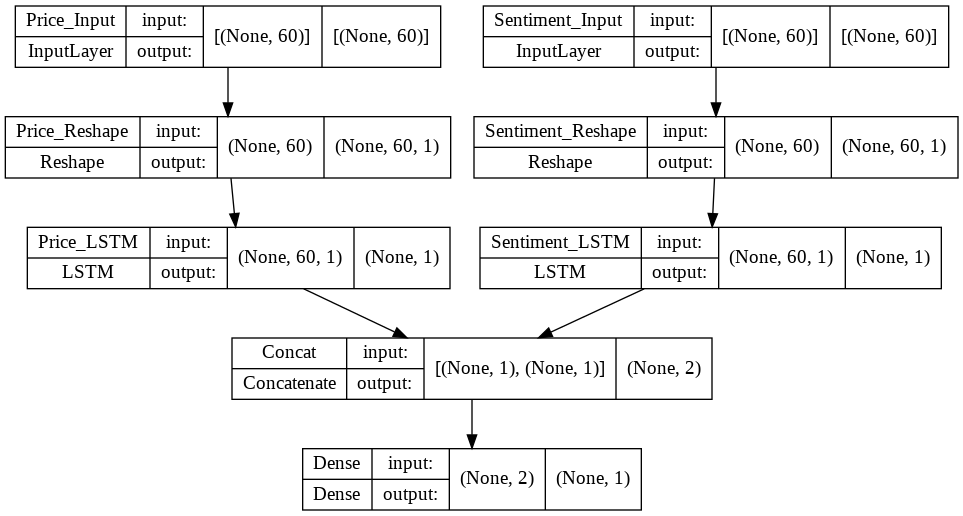

In [14]:
#===== Show Model Architecture Graphically:
plot_model(model,
           show_shapes=True,
           to_file='Model.png')

In [15]:
#======= Compile the Model:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# 🔰======= 🏋 [Fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) the model

In [61]:
history = model.fit(x={'Price_Input':X_price,
                       'Sentiment_Input':X_sent},
                    y=Y_price,
                    epochs=10)


Epoch 1/10
820/820 [==============================] - 18s 22ms/step - loss: 0.5960 - mse: 0.5960
Epoch 2/10
820/820 [==============================] - 18s 22ms/step - loss: 0.1683 - mse: 0.1683
Epoch 3/10
820/820 [==============================] - 18s 22ms/step - loss: 0.0596 - mse: 0.0596
Epoch 4/10
820/820 [==============================] - 19s 23ms/step - loss: 0.0216 - mse: 0.0216
Epoch 5/10
820/820 [==============================] - 20s 24ms/step - loss: 0.0075 - mse: 0.0075
Epoch 6/10
820/820 [==============================] - 21s 25ms/step - loss: 0.0029 - mse: 0.0029
Epoch 7/10
820/820 [==============================] - 32s 38ms/step - loss: 0.0015 - mse: 0.0015
Epoch 8/10
820/820 [==============================] - 28s 35ms/step - loss: 0.0011 - mse: 0.0011
Epoch 9/10
820/820 [==============================] - 35s 43ms/step - loss: 9.5600e-04 - mse: 9.5600e-04
Epoch 10/10
820/820 [==============================] - 34s 42ms/step - loss: 9.0324e-04 - mse: 9.0324e-04


# 🔰======= 🔎 Inspect the results:

## [Calling](https://www.tensorflow.org/api_docs/python/tf/keras/Model#call) a model on a single input

In [74]:
#========== review a single prediction:
xp_test = tf.reshape(X_price[100],(1,60))  #Reshaping is necessary because the model assumes inputs of shape (None,60)
xs_test = tf.reshape(X_sent[100],(1,60))   #Reshaping is necessary because the model assumes inputs of shape (None,60)

y_pred = model({'Price_Input':xp_test,
                'Sentiment_Input':xs_test},
                training=False)               #Model call is prefered over Model.predict when a small number of inputs is used

#=== Store Y values
y_true = Y_price[100]
print(y_pred,y_true,sep='\n')

tf.Tensor([[1.0425296]], shape=(1, 1), dtype=float32)
tf.Tensor([1.0233669], shape=(1,), dtype=float32)


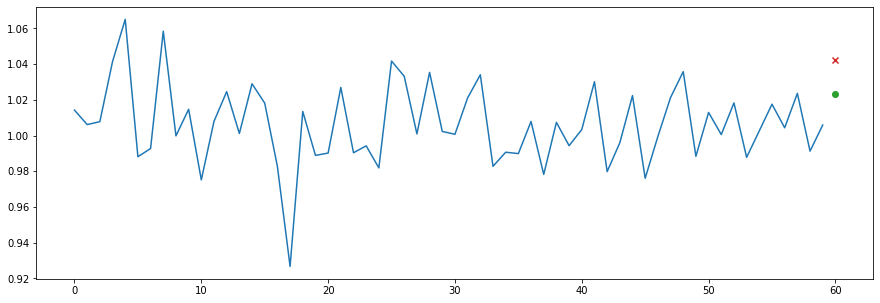

In [75]:
#======== Visualize the results
fig = plt.figure(figsize=(15,5))
ax = plt.subplot()

ax.plot(range(60),xp_test[0],label='xvalues',color='tab:blue')
ax.scatter(60,y_true,label='y_true',color='tab:green')
ax.scatter(60,y_pred,label='y_pred',color='tab:red',marker='x')